In [ ]:
pip install numpy pandas nltk transformers torch scikit-learn tensorflow matplotlib

In [1]:
import re
import string
import numpy as np
import pandas as pd
import csv

# 0. Load Data and Preprocess

In [ ]:
# Dataset's path
real_path = 'data/True.csv'
fake_path = 'data/Fake.csv'

In [3]:
def load_data(real_path, fake_path):
    real_data = pd.read_csv(real_path)
    fake_data = pd.read_csv(fake_path)
    real_data['label'] = 1
    fake_data['label'] = 0
    data = pd.concat([real_data, fake_data]).reset_index(drop=True)
    return data

In [4]:
# Clear the text
def wordopt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)

    return text

# 1. Analyse the feature

In [ ]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import subjectivity
from nltk import ne_chunk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('subjectivity')
nltk.download('wordnet')

In [6]:
# Function to load the NRC Emotion Lexicon
def load_nrc_lexicon(file_path):
      lexicon = {}
      with open(file_path, 'r') as file:
        reader = csv.reader(file, delimiter='\t')
        for row in reader:
          word, emotion, association = row
          if word not in lexicon:
            lexicon[word] = []
          if association == '1':
            lexicon[word].append(emotion)
      return lexicon

def count_emotions_in_text(words, lexicon):
      emotion_counts = {emotion: 0 for emotion in set(emotion for emotions in lexicon.values() for emotion in emotions)}

      for word in words:
        if word in lexicon:
          for emotion in lexicon[word]:
            emotion_counts[emotion] += 1

      return emotion_counts

nrc_lexicon = load_nrc_lexicon('data/NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt')
sid = SentimentIntensityAnalyzer()

In [7]:
def extract_feature(text):
    res = ()

    # Tokenize the text into words and sentences once
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Calculate word frequencies
    word_freq = FreqDist(words)

    # Calculate average sentence length
    avg_sentence_length = sum(len(sent.split()) for sent in sentences) / len(sentences) if sentences else 0
    res += (avg_sentence_length,)

    emotion_counts = count_emotions_in_text(words,nrc_lexicon)
    for _, val in emotion_counts.items():
      res += (val,)

    return np.array(res)

# 2. Feed to LLM

In [289]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.decomposition import PCA

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-albert-small-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-albert-small-v2')

# IMPORTANT: Change "mps" to "cuda" if using not Mac
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)

def vectorisation(text):
    # Tokenize the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=8).to(device) 
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Get the last hidden states
    last_hidden_states = outputs.last_hidden_state
    pooled_output = torch.mean(last_hidden_states, dim=1)

    return pooled_output.detach().cpu().numpy().flatten()

# 3. Try to read data

In [ ]:
fulldata = pd.DataFrame()
try:
    with open('label_feat_vect.pkl', 'r') as f:
        # Read the data from pkl and shuffle
        fulldata = pd.read_pickle('label_feat_vect.pkl')

# Create pkl file with label, features, and the vector
except FileNotFoundError:
    data = load_data(real_path, fake_path)
    data["text"] = data["text"].fillna("No text")
    data['text'] = data['text'].apply(wordopt)
    
    # Takes 15-20 minuts on Apple M2 Max
    vector = data['text'].apply(vectorisation)
    # Takes 2 minuts on Apple M2 Max
    feature = data['text'].apply(extract_feature)
    
    fulldata['label'] = data['label']
    fulldata['vector'] = vector
    fulldata['feature'] = feature
    
    # Save the data
    fulldata.to_pickle('label_feat_vect.pkl')

fulldata = fulldata.sample(frac=1)
fulldata.head()

# 4. Train and Test

In [223]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [321]:
def train_test(X):
    X_train, X_test, labl_train, labl_test = train_test_split(X, labl, test_size=0.3, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = Sequential([
        Input(shape=(X.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, labl_train, 
                epochs=40, 
                batch_size=32, 
                validation_data=(X_test, labl_test))
    
    loss, accuracy = model.evaluate(X_test, labl_test)
    
    return [loss, accuracy, history]

In [322]:
# Split the data for training and test
Xf = np.array(fulldata['feature'].tolist())
Xv = np.array(fulldata['vector'].tolist())
X = np.concatenate((Xf, Xv), axis=1)
labl = fulldata['label']

FV = train_test(X)
#F = train_test(Xf)
V = train_test(Xv)

print("Feature + vector:")
print(f"Test Loss: {FV[0]}")
print(f"Test Accuracy: {FV[1]}\n")

# print("Feature only:")
# print(f"Test Loss: {F[0]}")
# print(f"Test Accuracy: {F[1]}\n")

print("Vector only:")
print(f"Test Loss: {V[0]}")
print(f"Test Accuracy: {V[1]}\n")

Epoch 1/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7258 - loss: 0.5562 - val_accuracy: 0.8323 - val_loss: 0.3931
Epoch 2/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.8139 - loss: 0.4128 - val_accuracy: 0.8432 - val_loss: 0.3759
Epoch 3/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.8357 - loss: 0.3744 - val_accuracy: 0.8482 - val_loss: 0.3803
Epoch 4/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8389 - loss: 0.3594 - val_accuracy: 0.8550 - val_loss: 0.3433
Epoch 5/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8547 - loss: 0.3428 - val_accuracy: 0.8576 - val_loss: 0.3582
Epoch 6/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - accuracy: 0.8590 - loss: 0.3282 - val_accuracy: 0.8582 - val_loss: 0.3373
Epoch 7/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8640 - loss: 0.3211 - val_accuracy: 0.8608 - val_loss: 0.3445
Epoch 8/40
916/916 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8685 - loss: 0.3081 - val_accur

# 5.Plot the Results

In [265]:
import matplotlib.pyplot as plt

In [266]:
def plot_history(histories, title):
    plt.figure(figsize=(15, 10))
    
    # Train losses
    plt.subplot(2, 2, 1)
    for label, history in histories:
        plt.plot(history.history['loss'], label=f'{label} Training loss')
    plt.title('Train losses')
    plt.ylabel('Loss')
    plt.legend()
    
    # Validation losses
    plt.subplot(2, 2, 3)
    for label, history in histories:
        plt.plot(history.history['val_loss'], label=f'{label} Validation loss')
    plt.title('Validation losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Train accuracies
    plt.subplot(2, 2, 2)
    for label, history in histories:
        plt.plot(history.history['accuracy'], label=f'{label} Training accuracy')
    plt.title('Train accuracies')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Validation accuracies
    plt.subplot(2, 2, 4)
    for label, history in histories:
        plt.plot(history.history['val_accuracy'], label=f'{label} Validation accuracy')
    plt.title('Validation accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)
    plt.show()

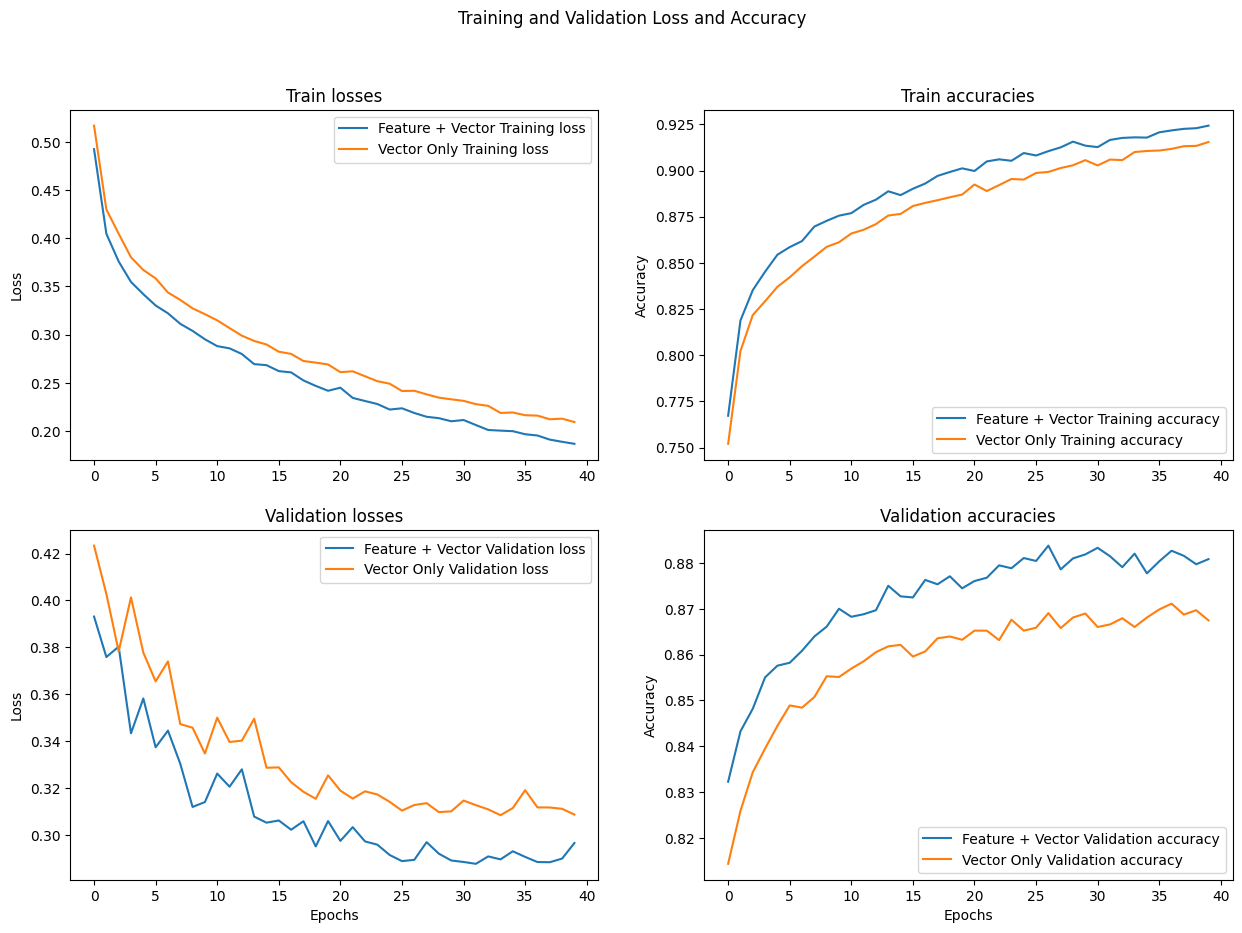

In [324]:
histories = [
    ('Feature + Vector', FV[2]),
    #('Feature Only', F[2]),
    ('Vector Only', V[2])
]

plot_history(histories, 'Training and Validation Loss and Accuracy')